# Resnet50

In this notebook the Resnet50 model with a fully connected head is tested

### imports

In [1]:
from court_dataset import CourtDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch
import torch.optim as optim
from tqdm import tqdm
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import os

### functions

In [2]:
def create_resnet50(num_coordinates=15):
    # Load pretrained ResNet50
    model = models.resnet50(weights='IMAGENET1K_V2')
    
    # Modify the output layer
    num_outputs = num_coordinates * 2  
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256), 
        nn.ReLU(),
        nn.Linear(256, num_outputs)           
    )
    return model

In [3]:
def train(model, train_loader, optimizer, device, epoch, criterion=torch.nn.MSELoss()):
    start_time = time.time()
    losses = []

    # Wrap train_loader with tqdm for a progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch") as pbar:
        for batch in train_loader:
            optimizer.zero_grad()
            model.train()

            # Forward pass
            inputs = batch[0].float().to(device)  # Input frames (images)
            keypoints_gt = batch[1].float().to(device)  # Ground truth keypoints
            outputs = model(inputs)  # Predicted keypoints
            
            # Compute loss
            loss = criterion(outputs, keypoints_gt.view(outputs.size()))  # Match shapes for regression
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track losses
            losses.append(loss.item())
            duration = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

            # Update the tqdm bar
            pbar.set_postfix({
                'loss': round(loss.item(), 6),
                'time': duration
            })
            pbar.update(1)
            
    return np.mean(losses)

def compute_mse(points, positions, img_size):
    #loop over points
    mse = []

    for i in range(len(points)):
        # get the point
        point = points[i]
        # get the position
        position = positions[i]

        # if the point is outside the image, skip
        if point[0] < 0 or point[0] >= img_size[0] or point[1] < 0 or point[1] >= img_size[1]:
            continue

        # if the position is -1,-1 return the maximum distance
        if position[0] == -1 and position[1] == -1:
            continue
        
        # calculate the distance
        distance = np.linalg.norm(np.array(point) - np.array(position))

        # add to mse
        mse.append(distance**2)

    # return the mean
    return np.mean(mse)


def compute_counts(points, positions, img_size, threshold=4):
    # check that len is the same
    assert len(points) == len(positions) 
    
    #loop over points
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(len(points)):
        # get the point
        point = points[i]
        # get the position
        position = positions[i]
        
        # calculate the distance
        distance = np.linalg.norm(np.array(point) - np.array(position))

        # add to tp, fp, fn, tn
        if distance <= threshold:
            # if point is outside the frame
            if point[0] < 0 or point[0] >= img_size[0] or point[1] < 0 or point[1] >= img_size[1]:
                tn += 1
            else:
                tp += 1
        else:
            #if point is outside the frame
            if point[0] < 0 or point[0] >= img_size[0] or point[1] < 0 or point[1] >= img_size[1]:
                fn += 1
            else:
                fp += 1

    # return the metrics
    return tp, fp, tn, fn


def calculate_metrics(tp, fp, tn, fn):
    # Avoid division by zero for precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # F1-score calculation
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Accuracy calculation
    total = tp + fp + tn + fn
    accuracy = (tp + tn) / total if total > 0 else 0.0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    

def validate(model, val_loader, device, criterion=torch.nn.MSELoss(), threshold=4, img_size=(1280, 720)):
    model.eval()  # Set the model to evaluation mode
    tp, fp, tn, fn = 0, 0, 0, 0  # Initialize counts
    losses = []
    mse_scores = []

    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        for batch_idx, batch in enumerate(val_loader):
            with torch.no_grad():
                # Prepare data
                inputs = batch[0].float().to(device)  # Input images
                keypoints_gt = batch[1].float().to(device)  # Ground truth keypoints
                outputs = model(inputs)  # Predicted keypoints
                
                # Compute loss
                loss = criterion(outputs, keypoints_gt.view(outputs.size()))  # Match shapes for regression
                losses.append(loss.item())

                # First loop: Iterate over each item in the batch
                for i in range(outputs.shape[0]):  # Loop over batch samples
                    # get predictions
                    positions = outputs[i].view(-1, 2).cpu().numpy()
                    # move to cpu
                    keypoints = keypoints_gt[i].cpu().numpy()
                    
                    #Compute MSE for the batch
                    mse = compute_mse(keypoints, positions, img_size)
                    mse_scores.append(mse)

                    # Compute TP, FP, TN, FN for the batch
                    item_tp, item_fp, item_tn, item_fn = compute_counts(keypoints, positions, img_size, threshold)
                    tp += item_tp
                    fp += item_fp
                    tn += item_tn
                    fn += item_fn

                # Update the tqdm bar
                pbar.set_postfix({
                    'loss': round(np.mean(losses), 6)
                })
                pbar.update(1)

    # Calculate overall metrics
    mean_loss = np.mean(losses)
    mean_mse = np.mean(mse_scores)
    metrics = calculate_metrics(tp, fp, tn, fn)

    return mean_loss, mean_mse, metrics

In [4]:
# Seed for reproducibility
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def setup_paths(exp_id):
    exps_path = f'./exps/{exp_id}'
    if not os.path.exists(exps_path):
        os.makedirs(exps_path)
    
    paths = {
        "model_last": os.path.join(exps_path, 'model_last.pth'),
        "model_best": os.path.join(exps_path, 'model_best.pth'),
        "log": os.path.join(exps_path, 'training_log.txt')
    }
    return paths

In [5]:
def create_dataloaders(dataset_path, batch_size):
    train_dataset = CourtDataset(
        path=dataset_path,
        split="train",
        input_height=720,
        input_width=1280,
        model_height=288,
        model_width=512,
        augment=True,
        selected_points=None
    )
    
    val_dataset = CourtDataset(
        path=dataset_path,
        split="validation",
        input_height=720,
        input_width=1280,
        model_height=288,
        model_width=512,
        augment=False,
        selected_points=None
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

In [ ]:
def training():
    set_seed(SEED)
    best_val_loss = float("inf")
    no_improvement_steps = 0  
    val_intervals = 2
    selected_gpus = [0,1]
    patience = 10 
    dataset_path = "../../00_Dataset"
    batch_size = 64
    num_coordinates = 15  # Number of keypoints
    num_epochs = 100
    learning_rate = 1e-3
    loss_fn = nn.MSELoss()
    
    #create name based aon augment, input and output number
    exp_id = "CourtResNet50_test"
    
    # Set up paths for experiment and logging
    paths = setup_paths(exp_id)

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Start logging to a file
    with open(paths["log"], 'w') as log_file:
        log_file.write("Epoch,Train_Loss,Val_Loss,MSED,Accuracy,F1\n")

        # Create data loaders
        train_loader, val_loader = create_dataloaders(dataset_path, batch_size)

        # Set up the model
        # Model setup
        model = create_resnet50(num_coordinates=num_coordinates)
        model = nn.DataParallel(model, device_ids=selected_gpus)
        model = model.to(f'cuda:{selected_gpus[0]}')
        
        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=3
        )

        # Set the primary device (first GPU in the list)
        device = torch.device(f'cuda:{selected_gpus[0]}')
        
        # train epochs
        for epoch in range(1, num_epochs + 1):
            # set epoch seed
            set_seed(SEED + epoch)
            
            # Training step
            train_loss = train(model, train_loader, optimizer, device, epoch, criterion=criterion)
            log_file.write(f"{epoch},{train_loss}")

            # Validation step
            if epoch > 0 and epoch % val_intervals == 0:
                val_loss, mean_mse, metrics = validate(model, val_loader, device, criterion=criterion)
                log_file.write(f",{val_loss},{mean_mse},{metrics['accuracy']},{metrics['f1']}\n")

                # Step the scheduler based on validation loss
                scheduler.step(val_loss)

                # Save the best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_steps = 0  # Reset counter
                    #save model
                    torch.save(model.module.state_dict(), paths["model_best"])
                else:
                    no_improvement_steps += 1  # Increment counter

                # Early stopping check
                if no_improvement_steps >= patience:
                    print("Early stopping triggered. No improvement in validation for", patience, "validation steps.")
                    break
            else:
                log_file.write("\n")  # Log training loss only if no validation

            # Save the latest model checkpoint
            torch.save(model.module.state_dict(), paths["model_last"])

        return paths["model_best"]

def load_model(best_model_path):
    num_coordinates = 15
    selected_gpus = [0,1]
    device = torch.device(f'cuda:{selected_gpus[0]}')
    
    # Recreate the model architecture
    model = create_resnet50(num_coordinates=num_coordinates)
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model = model.to(f'cuda:{selected_gpus[0]}')
    model.eval()  # Set the model to evaluation mode

    print(f"Model loaded from: {best_model_path}")
    return model

## Training

In [7]:
best_model_path = training()
model = load_model(best_model_path)

Samples: 1042
Samples: 177


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/bevo/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.6MB/s]
Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97batch/s, loss=195]


Model loaded from: ./exps/CourtResNet50_test/model_best.pth


/tmp/ipykernel_2625113/603256090.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


In [ ]:
def plot_random_val_image(model, val_loader, device, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode

    # Select a random batch from the DataLoader
    random_batch_idx = random.randint(0, len(val_loader) - 1)
    for i, batch in enumerate(val_loader):
        if i == random_batch_idx:
            inputs, keypoints_gt = batch[0], batch[1]
            break

    # Select a random sample from the batch
    idx = random.randint(0, inputs.size(0) - 1)
    input_image = inputs[idx].to(device).unsqueeze(0)  # Select image, add batch dimension
    ground_truth = keypoints_gt[idx].cpu().numpy()  # Ground truth keypoints

    # Perform prediction
    with torch.no_grad():
        predictions = model(input_image).view(-1, 2).cpu().numpy()  # Predicted keypoints

    # Convert the image for visualization
    img = inputs[idx].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) to (H, W, C)

    # De-normalize the image
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Ensure pixel values are in range [0, 1]
    img = (img * 255).astype("uint8")  # Convert to [0, 255] range for visualization

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.scatter(ground_truth[:, 0], ground_truth[:, 1], c="green", label="Ground Truth", s=40)
    plt.scatter(predictions[:, 0], predictions[:, 1], c="red", label="Prediction", s=40)
    plt.legend()
    plt.title(f"Random Validation Image\nGreen: Ground Truth, Red: Prediction")
    plt.axis("off")
    plt.show()


# Set the primary device (first GPU in the list)
train_loader, val_loader = create_dataloaders("../../00_Dataset", 32)
selected_gpus = [0,1]
device = torch.device(f'cuda:{selected_gpus[0]}')

Samples: 1042
Samples: 177


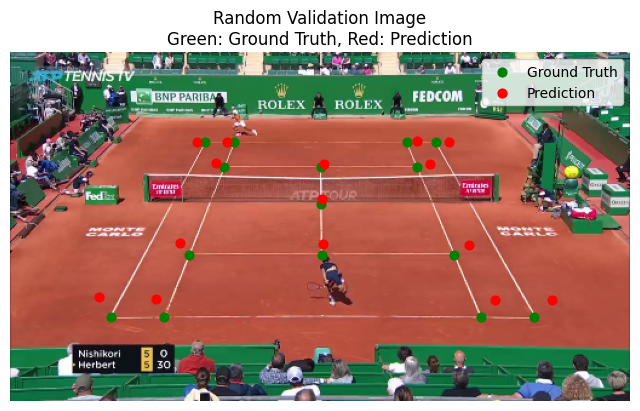

In [9]:
plot_random_val_image(model, val_loader, device)